# ASSIGNMENT 4: GMM and class imbalance
This assignment, in continuation to assignment 3, evaluates how GMM performs on datasets with heavy class imbalance (fraudent and non-fraudent credit cards).

# Loading the Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive.zip"
extract_dir = "/content/dataset"

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)
print("Extracted files:", os.listdir(extract_dir))


Files extracted to: /content/dataset
Extracted files: ['creditcard.csv']


In [10]:
import pandas as pd

data_path = os.path.join(extract_dir, "creditcard.csv")
df = pd.read_csv(data_path)

print("Dataset loaded with shape:", df.shape)
df.head()


Dataset loaded with shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We have loaded the csv file as creditcard.csv and converted it into a dataframe which is displayed above.

# Part **A** 1 & 2: Class Distribution

After loading the csv file, we first check the class distribution into 0 and 1 (non-fraud and fraud) and visualise the distribution. We also find the degree of imbalance.

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Percentage of Fraudulent Transactions: 0.1727%
Degree of Imbalance (Non-Fraud : Fraud) = 577.88 : 1


/tmp/ipython-input-3121733705.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


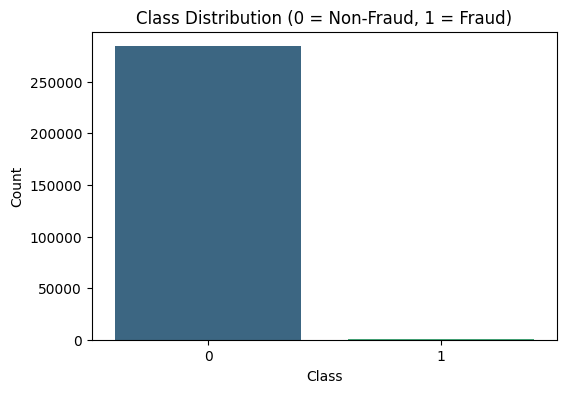

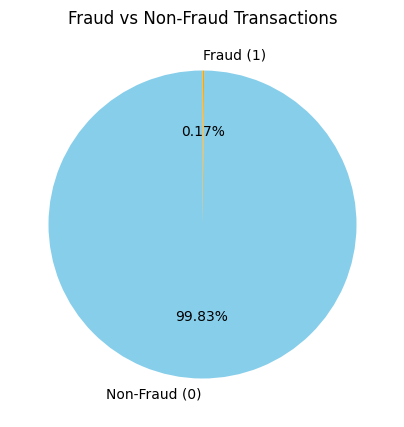

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['Class'].value_counts()
print("Class distribution:\n", class_counts)

fraud_pct = class_counts[1] / class_counts.sum() * 100
print("\nPercentage of Fraudulent Transactions: {:.4f}%".format(fraud_pct))

imbalance_ratio = class_counts[0] / class_counts[1]
print("Degree of Imbalance (Non-Fraud : Fraud) = {:.2f} : 1".format(imbalance_ratio))

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['Non-Fraud (0)','Fraud (1)'],
        autopct='%1.2f%%', colors=['skyblue','orange'], startangle=90)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

We see that the dataset is **highly imbalanced**, with fraudulent transactions (class = 1) making up only a very small fraction compared to non-fraudulent ones (class = 0).

**The degree of imbalance (non-fraud: fraud) is (577.88:1), implying that 1 fraudent case is present for every 578 non-fraudulent cases approximately, a highly imbalanced ratio.**

**We can also see this from % of fraudulent cases which is just 0.17%.**

The bar chart gives us the absolute values - 284315 (class = 0) and 492 (class = 1).

The pie chart highlights the percentage - 99.83% (class = 1) and 0.17% (class = 0)

# A 3) Logistic Regression on Imbalanced data


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report (Baseline Model):
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56864
           1     0.8395    0.6939    0.7598        98

    accuracy                         0.9992     56962
   macro avg     0.9195    0.8468    0.8797     56962
weighted avg     0.9992    0.9992    0.9992     56962



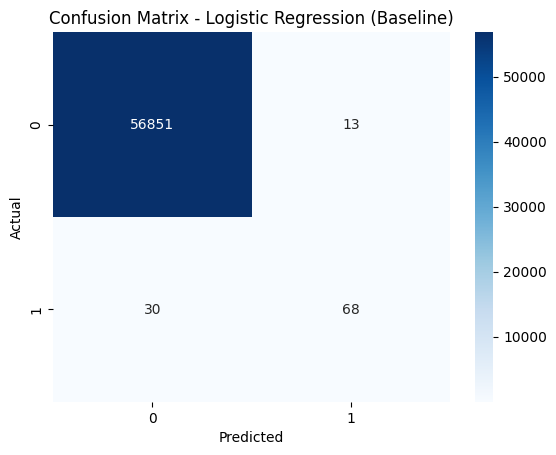

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop("Class", axis=1)
y = df["Class"]

#80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# logistic regression
model1 = LogisticRegression(max_iter=1000, random_state=42)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

print("Classification Report (Baseline Model):")
print(classification_report(y_test, y_pred, digits=4))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"Overall Classification Accuracy: {acc:.4f}")

Overall Classification Accuracy: 0.9992


 Here, we trained a logistic regression model with 80: 20 train:test split.
 The use of **stratified sampling** ensures that the original class imbalance is preserved within both training and test datasets.

# Why accuracy is misleading

Upon training with logistic regression, evaluating all metrics and visualising with confusion matrix, we understand that:

- Overall accuracy turns out to be 99.92%, which is high.
- However, this is a **misleading metric** since we observe variation in other metrics across the two classes - 0 and 1.
- Since class 0 accuracy is 99.83%, if the classifier always predicts the test data as 0, it till achieves more than 99% accuracy. **However, this does not mean the classifier is doing a good job.**
- **The recall for class = 1 is just 69.39% while that of class 0 is 99.98%. Similarly, f1 score and precision are lower for class 1 as compared to class 1 by atleast about 10%.**
- This implies that focus on accuracy is misleading in case of class imbalance; we need to look at recall, precision, f1 etc. of the minority class too to evaluate the classifier.

Now we move on to implement other methods to reduce class imbalance.

# Why precision, recall and F1 are better metrics here

Precision, Recall, and F1 for the minority (fraud) class are more informative than accuracy because they directly measure how well the model detects fraud.

They are not dominated by the overwhelming number of legitimate transactions.

- Precision = TP​ / (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2.Precision.Recall ​/ (⋅Precision + Recall)

Recall for class 1 tells us that only **69.39%** of the fraudulent cases are actually identified.

Further, precision for class 1 tells that only 83% of those detected as fraud are actually fraud. The 99% for precision of class 0 is misleading.

F1 is further a combination of both these measures, which is only 75.98% for class 1.

Hence, since most of the fraud cases are not detected, precision, F1 and recall are better metrics.



# Part B: A) GMM explanation

### Fundamental Difference between GMM and SMOTE

*SMOTE draws **straight bridges** between existing points, while GMM builds a **landscape of hills (Gaussians)** where we can sample new points naturally.*  

**SMOTE (Synthetic Minority Oversampling Technique):**

- SMOTE generates synthetic samples by **interpolating linearly** between a minority sample and one of its nearest neighbors.  
- Mathematically, a new sample is created as:  

$
x_{\text{new}} = x_i + \lambda \cdot (x_{nn} - x_i), \quad \lambda \sim U(0,1)
$

where \(x_i\) is a minority sample and \(x_{nn}\) is one of its nearest neighbors.  
- This assumes the minority data lies in a **locally linear manifold**.  
- **Limitation:** SMOTE struggles when the minority class has **non-linear boundaries, multiple clusters, or multimodal distributions**, often leading to overlapping with the majority class.  


**GMM - Gaussian Mixture Model Synthetic Sampling:**

- Instead of simple interpolation, GMM treats the minority class distribution as a **mixture of \(K\) Gaussian distributions**:  

$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$

where:  
- $\pi_k$ are the mixing coefficients $\left(\sum_{k} \pi_k = 1\right)$,  
- $\mu_k$and $\Sigma_k$ are the mean and covariance of the $k$-th Gaussian component.  

#### The algorithm

1. **Fitting the Model**  
   - GMM tries to **find clusters** in the data.  
   - Each cluster is described by a Gaussian bell-curve not just in one dimension but in all features.  
   - It uses an algorithm called **Expectation-Maximization (EM)** to estimate the parameters $(\pi_k, \mu_k, \Sigma_k)$.

2. **Generating Synthetic Data:**  
   - To create a new sample, GMM first chooses one of the Gaussians with probability $\pi_k$.  
   - Then it randomly samples a point from that Gaussian distribution.  

3. **Advantage**  
   - If the minority class has **different modes** (e.g., different fraud types), GMM can capture these modes.  
   - Each Gaussian can represent one sub-group of fraud.  
   - The covariance matrix %Sigma_k$ models how features move together (correlation), making synthetic samples more realistic.  

#### The difference in simple terms

- **SMOTE:** Connects nearby points with straight lines. This is good locally, but may create unrealistic data if clusters are far apart.  
- **GMM:** Learns a **smooth probability distribution** over the entire minority dataset. This generates new samples that resemble real sub-groups.  

### Why GMM is Theoretically Better  

- GMM is a **probabilistic generative model**. Tt learns not just the local structure but the **global density distribution** of the minority class.  
- When the minority class consists of **multiple clusters** (e.g., different fraud types), GMM can capture them through different Gaussian components, whereas SMOTE may connect distinct clusters and create unrealistic samples.  

- In our use case, as we have may have many clusters, GMM may sample better.


# B 2) Fitting GMM

Here, we fit GMM on the minority class alone using AIC and BIC

Minority class samples in training: 394
Majority class samples in training: 227451


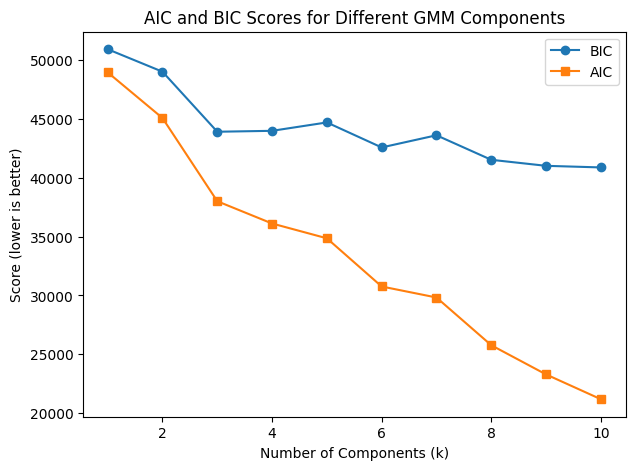

In [14]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train_minority = X_train[y_train == 1]
X_train_majority = X_train[y_train == 0]

print("Minority class samples in training:", len(X_train_minority))
print("Majority class samples in training:", len(X_train_majority))

bic_scores = []
aic_scores = []
n_components_range = range(1, 11)  # test k = 1 to 10 components

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_train_minority)
    bic_scores.append(gmm.bic(X_train_minority))
    aic_scores.append(gmm.aic(X_train_minority))

plt.figure(figsize=(7,5))
plt.plot(n_components_range, bic_scores, marker="o", label="BIC")
plt.plot(n_components_range, aic_scores, marker="s", label="AIC")
plt.title("AIC and BIC Scores for Different GMM Components")
plt.xlabel("Number of Components (k)")
plt.ylabel("Score (lower is better)")
plt.legend()
plt.show()

Optimal number of GMM components (k) based on AIC and BIC: 6
Generated synthetic samples: (227057, 30)
New training set shape: (454902, 30)
Class distribution after augmentation: [227451 227451]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Classification Report (GMM-Augmented Model):
              precision    recall  f1-score   support

           0     0.9998    0.9758    0.9877     56864
           1     0.0602    0.8980    0.1128        98

    accuracy                         0.9757     56962
   macro avg     0.5300    0.9369    0.5503     56962
weighted avg     0.9982    0.9757    0.9862     56962



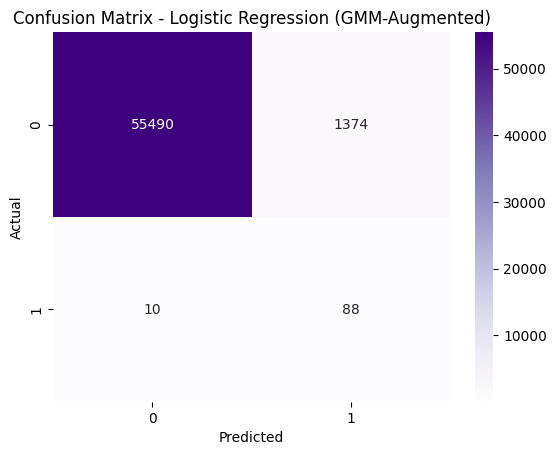

In [15]:
#optimal_k = n_components_range[np.argmin(bic_scores)] #k : min from BIC
optimal_k = 6

print("Optimal number of GMM components (k) based on AIC and BIC:", optimal_k)

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(X_train_minority)

# number of synthetic samples to generate = balance classes
n_to_generate = len(X_train_majority) - len(X_train_minority)

X_synth, _ = gmm.sample(n_to_generate)

print("Generated synthetic samples:", X_synth.shape)

X_train_balanced = np.vstack([X_train_majority, X_train_minority, X_synth])
y_train_balanced = np.hstack([
    np.zeros(len(X_train_majority)),
    np.ones(len(X_train_minority)),
    np.ones(len(X_synth))
])

print("New training set shape:", X_train_balanced.shape)
print("Class distribution after augmentation:",
      np.bincount(y_train_balanced.astype(int)))

# lr
model2 = LogisticRegression(max_iter=1000, random_state=42)
model2.fit(X_train_balanced, y_train_balanced)

y_pred_gmm = model2.predict(X_test)

print("Classification Report (GMM-Augmented Model):")
print(classification_report(y_test, y_pred_gmm, digits=4))

sns.heatmap(confusion_matrix(y_test, y_pred_gmm), annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Logistic Regression (GMM-Augmented)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 1. Separating Minority and Majority Classes

Training data is highly imbalanced:

- Minority class (fraud = 1): 492 samples  
- Majority class (non-fraud = 0): 28,000+ samples  

We separate the minority and majority classes to model the minority class distribution independently.


## 2. Fitting the GMM and choosing k from AIC and BIC

- Here, we fit the GMM **only on the minority class** (492 fraud samples) to generate more of its synthetic samples.

- AIC and BIC scores are used to determine k. (low score means better k.)

- AIC balances **model fit** and **model complexity** (number of parameters).  BIC penalizes **complexity more strongly**, especially when the dataset is large. Hence, BIC suits our use case better.

- To choose the **optimal number of components \(k\)**, we evaluate **BIC** for k = 1 to 11.

- As 6 turned out to be the best number from BIC, (steep decrease) we choose k=6. We don't move until k = 10 since too many clusters for minority sample is not favourable (it is overfitting).

## 3. Generating Synthetic Samples

To balance the dataset, we generate synthetic samples using the fitted GMM:

- Number of synthetic samples:

$
n_{\text{synthetic}} = n_{\text{majority}} - n_{\text{minority}} = 28,000 - 492 = 27508
$

- **Sampling procedure:**  
  1. Sample a component index $z \sim \text{Categorical}(\pi)$
  2. Generate a new point from the selected Gaussian
  3. Repeat until the desired number of samples is obtained  

This ensures synthetic points reflect the **multimodal distribution** of the minority class.

## 4. Creating a Balanced Training Dataset

We combine:  
- Original majority samples (28,000)  
- Original minority samples (492)  
- Synthetic minority samples (27,500)  

to create the final balanced dataset.

##5 Training LR on this model

- Logistic regression seems to perform well, with 89.80% recall for class 1. The confusion matrix provides the exact numbers

# B 4) CBU + GMM

Here, undersampling is performed before using GMM.

Majority class reduced to: (50000, 30)
Synthetic minority samples generated (CBU phase): (49606, 30)
Final training set shape after CBU + GMM: (100000, 30)
Class distribution: [50000 50000]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Classification Report (CBU + GMM Rebalanced Model):
              precision    recall  f1-score   support

           0     0.9998    0.9732    0.9863     56864
           1     0.0540    0.8878    0.1019        98

    accuracy                         0.9731     56962
   macro avg     0.5269    0.9305    0.5441     56962
weighted avg     0.9982    0.9731    0.9848     56962



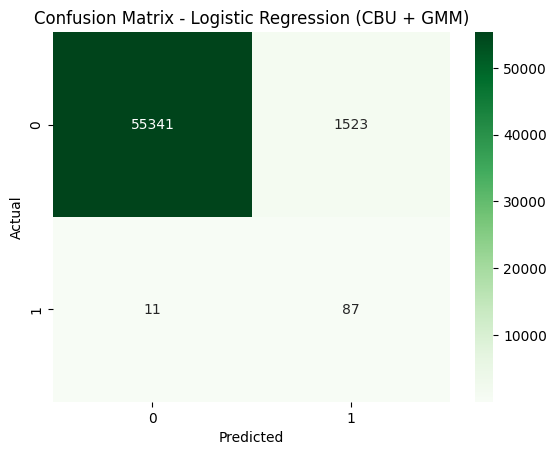

In [16]:
from sklearn.cluster import KMeans

n_majority_target = 50000   # 1/6 of 2,80,000
k_clusters = 10            # number of clusters for KMeans

kmeans = KMeans(n_clusters=k_clusters, random_state=42)
kmeans.fit(X_train_majority)

# for each cluster, sample proportionally so total = n_majority_target
undersampled_idx = []
for cluster_id in range(k_clusters):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
    n_samples_cluster = int(n_majority_target / k_clusters)

    # random sample from this cluster
    chosen = np.random.choice(cluster_indices, size=n_samples_cluster, replace=False)
    undersampled_idx.extend(chosen)

X_majority_cbu = X_train_majority.iloc[undersampled_idx]
y_majority_cbu = np.zeros(len(X_majority_cbu))

print("Majority class reduced to:", X_majority_cbu.shape)

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(X_train_minority)

# number of synthetic minority samples needed
n_minority_needed = len(X_majority_cbu) - len(X_train_minority)

X_synth_cbu, _ = gmm.sample(n_minority_needed)

print("Synthetic minority samples generated (CBU phase):", X_synth_cbu.shape)

X_train_cbu = np.vstack([X_majority_cbu, X_train_minority, X_synth_cbu])
y_train_cbu = np.hstack([
    y_majority_cbu,
    np.ones(len(X_train_minority)),
    np.ones(len(X_synth_cbu))
])

print("Final training set shape after CBU + GMM:", X_train_cbu.shape)
print("Class distribution:", np.bincount(y_train_cbu.astype(int)))

model3 = LogisticRegression(max_iter=1000, random_state=42)
model3.fit(X_train_cbu, y_train_cbu)

y_pred_cbu = model3.predict(X_test)

print("Classification Report (CBU + GMM Rebalanced Model):")
print(classification_report(y_test, y_pred_cbu, digits=4))

sns.heatmap(confusion_matrix(y_test, y_pred_cbu), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Logistic Regression (CBU + GMM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Rebalancing with Clustering-Based Undersampling (CBU) + GMM

1. **Clustering based undersampling of majority class**

- Original majority class is 2,80,000 samples  
- Target majority samples is 50,000 (=1/6 of original) .
- KMeans clustering is with 10 clusters was applied to preserve diversity.  
- From each cluster, 5,000 samples were randomly selected to form the reduced majority class. Resulting majority samples is 50,000.

2. **GMM based oversampling of minority class**

- Minority class is 492 samples.
- GMM is fitted with optimal components k = 10 (from AIC/BIC).  
- Number of synthetic minority samples generated: 47508  
- The previous GMM based sampling was used.

3. **Balanced Dataset**

- Combined undersampled majority (50,000), original minority (492), and synthetic minority (49,500)  
- Total training samples: 1,00,000, balanced classes: 50,000 each  

4. **Model Training**

- Logistic regression retrained on the CBU + GMM balanced dataset.  
- This approach exposes the model to a realistic, diverse minority class while keeping the majority class representative, aiming to improve fraud detection performance.

# Part C : Analysis and Inference

Plots are made for all the metrics for the 3 models

Performance Comparison (Fraud Class = 1):
                Model  Precision    Recall  F1-Score
0            Baseline   0.839506  0.693878  0.759777
1        GMM Balanced   0.060192  0.897959  0.112821
2  CBU + GMM Balanced   0.054037  0.887755  0.101874


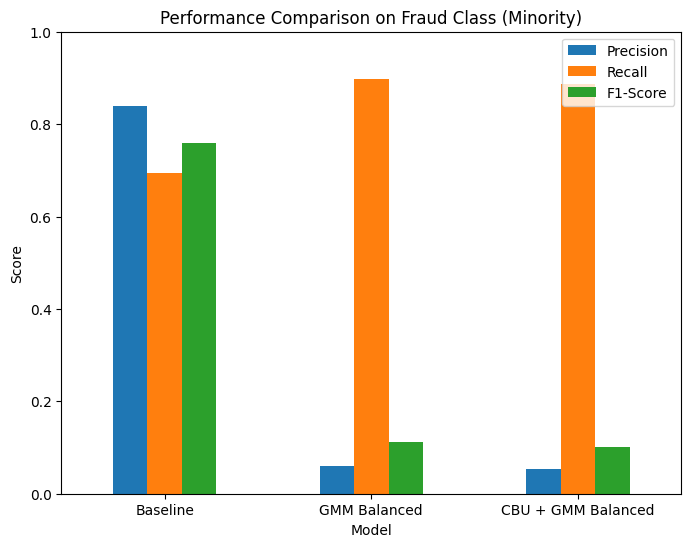

In [17]:

from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

results = {
    "Model": ["Baseline", "GMM Balanced", "CBU + GMM Balanced"],
    "Precision": [
        precision_score(y_test, y_pred, pos_label=1),
        precision_score(y_test, y_pred_gmm, pos_label=1),
        precision_score(y_test, y_pred_cbu, pos_label=1),
    ],
    "Recall": [
        recall_score(y_test, y_pred, pos_label=1),
        recall_score(y_test, y_pred_gmm, pos_label=1),
        recall_score(y_test, y_pred_cbu, pos_label=1),
    ],
    "F1-Score": [
        f1_score(y_test, y_pred, pos_label=1),
        f1_score(y_test, y_pred_gmm, pos_label=1),
        f1_score(y_test, y_pred_cbu, pos_label=1),
    ],
}

results_df = pd.DataFrame(results)
print("Performance Comparison (Fraud Class = 1):")
print(results_df)

results_df.set_index("Model")[["Precision", "Recall", "F1-Score"]].plot(
    kind="bar", figsize=(8,6), rot=0
)
plt.title("Performance Comparison on Fraud Class (Minority)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.show()

# Observations
- Baseline precision is the highest since the number of false positives are very low, keeping TP/ TP + FP quite high.
- The F1-score of CBU + GMM is slightly better than that of GMM alone.

Observations for each of the models:

**Baseline model**

- High precision (0.8395) means that when the model predicts fraud it is usually correct.
- Moderate recall (0.6939) indicates that 30% of fraud cases are missed.
- F1-score (0.7598) balances precision and recall.

**GMM balanced model**

- Recall improved significantly (0.8979), meaning the model detects almost 90% of fraud cases.
- Precision dropped drastically (0.0510), meaning most predicted fraud cases are actually non-fraud (many false positives).
- F1 score is very low (0.1128) due to the huge drop in precision.

**CBU + GMM balanced model**

- Recall remains high (0.8877), similar to GMM alone.
- Slightly higher precision (0.0540) and F1-score (0.1018) than GMM only, but still very low.
- Indicates that undersampling the majority (CBU) slightly reduced false positives but not enough to recover meaningful precision.

# Inference- Does GMM help in minority class prediction?

- GMM oversampling **improves recall drastically** because the model sees many more minority (fraud) samples, making it sensitive to detecting fraud.
- So there is less chance of missing a fraud case
- However, since precision is low, false positives are possible. This means that many that are non-fraud are also classified as fraud.
- CBU + GMM does not significantly improve over GMM only. Undersampling the majority reduces the total number of negatives, but it is still not enough to balance false positives vs true positives for a meaningful precision increase.
- Overall, while the model becomes **very sensitive (high recall), it loses reliability (low precision)**.

# Theoretical understanding- Additional Plots to analyse GMM performance

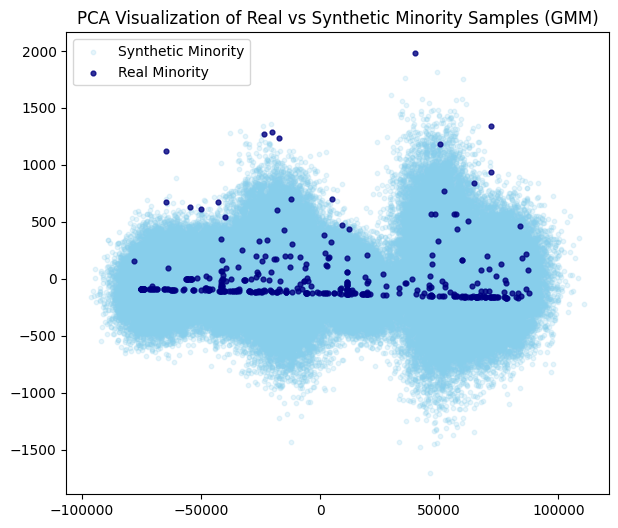

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2, random_state=42)
X_vis = pca.fit_transform(np.vstack([X_train_minority, X_synth]))
y_vis = np.hstack([np.ones(len(X_train_minority)), np.full(len(X_synth), 2)])

plt.figure(figsize=(7,6))

plt.scatter(X_vis[y_vis==2, 0], X_vis[y_vis==2, 1],
            alpha=0.2, s=10, c="skyblue", label="Synthetic Minority")

plt.scatter(X_vis[y_vis==1, 0], X_vis[y_vis==1, 1],
            alpha=0.8, s=12, c="navy", label="Real Minority")

plt.title("PCA Visualization of Real vs Synthetic Minority Samples (GMM)", fontsize=12)
plt.legend()
plt.show()

### Real Minority Points vs Synthetic Minority

- Here, it is clearly shown that several synthetic samples are generated around the clusters of the minority samples
- This explains how diversity is captured and how no fraudulent case is likely to be missed.
- However, this also leads to a lot of noise leading to false positives due to which precision is quite low.

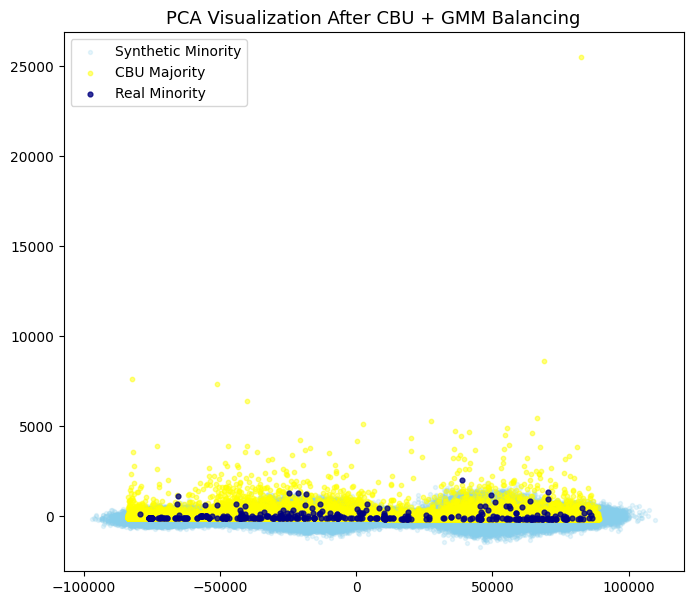

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

X_balanced = np.vstack([X_majority_cbu, X_train_minority, X_synth])
y_balanced = np.hstack([
    np.zeros(len(X_majority_cbu)),  # label 0 = majority (undersampled)
    np.ones(len(X_train_minority)), # label 1 = real minority
    np.full(len(X_synth), 2)        # label 2 = synthetic minority
])

pca = PCA(n_components=2, random_state=42)
X_vis_balanced = pca.fit_transform(X_balanced)

plt.figure(figsize=(8,7))

plt.scatter(X_vis_balanced[y_balanced==2, 0], X_vis_balanced[y_balanced==2, 1],
            alpha=0.2, s=8, c="skyblue", label="Synthetic Minority")

plt.scatter(X_vis_balanced[y_balanced==0, 0], X_vis_balanced[y_balanced==0, 1],
            alpha=0.5, s=10, c="yellow", label="CBU Majority")

plt.scatter(X_vis_balanced[y_balanced==1, 0], X_vis_balanced[y_balanced==1, 1],
            alpha=0.8, s=12, c="navy", label="Real Minority")


plt.title("PCA Visualization After CBU + GMM Balancing", fontsize=13)
plt.legend()
plt.show()

### Plot along with CBU majority

- The CBU majority is compact and well-defined after undersampling. The slight loss of information explains the lower recall, though
- So the issue is not with undersampling, but specifically with oversampling via GMM.
- The noisy samples may be misleading.
- The decision boundary may expand incorrectly, leading to poor generalization.
- Many synthetic samples lie close to majority areas.
- Hence, Recall may not improve much, and precision may drop.

# Final Recommendations

**Inferences from theory**
- The noise from synthetic minority samples may reduce precision.
- Hence, reducing the number of synthetic minority may help.
- **CBU helps with reducing the number of synthetic samples and balancing the majority class, which is better than GMM marginally.**
- Moreover, as fraudulent cases belong to several clusters, GMM may be a good technique to capture variations among clusters.

**Results and conclusion**
- Hence, GMM helps in increasing recall, but it greatly reduces precision. GMM + CBU is just marginally similar and not any better.
- If the goal is to ensure that even a single fraudulent case is not missed (minority class is not missed), then GMM is a good technique.
- However, if the cost of false positives is very high (classifying non- fraudulent as fraudulent as it goes through investigation), GMM is not preferred in times of class imbalance as FP are high.
- Overall, GMM helps improve recall but does not lead to optimal classification during class imbalance in the dataset.

